# 1.데이터 불러오기, 전처리

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font="Malgun Gothic")

df_info = pd.read_csv("../data/raw/big_data_set1_f.csv", encoding="cp949")
df_usage = pd.read_csv("../data/raw/big_data_set2_f.csv", encoding="cp949")
df_customer = pd.read_csv("../data/raw/big_data_set3_f.csv", encoding="cp949")

In [95]:
# 컬럼명 리네이밍
rename_info = {
    "ENCODED_MCT": "num",        # 가맹점ID
    "MCT_BSE_AR": "addr",        # 주소
    "MCT_NM": "name",            # 가맹점명
    "MCT_BRD_NUM": "brand_cd",   # 브랜드코드
    "MCT_SIGUNGU_NM": "sigungu", # 지역(시군구)
    "HPSN_MCT_ZCD_NM": "biz_type", # 업종
    "HPSN_MCT_BZN_CD_NM": "market", # 상권
    "ARE_D": "open",             # 개설일
    "MCT_ME_D": "close"          # 폐업일
}

rename_usage = {
    "ENCODED_MCT": "num",          # 가맹점ID
    "TA_YM": "ym",                 # 기준년월

    "MCT_OPE_MS_CN": "oper_month_grp", # 운영 개월 구간
    "RC_M1_SAA": "sales_grp",      # 매출금액 구간
    "RC_M1_TO_UE_CT": "txn_cnt_grp", # 매출건수 구간
    "RC_M1_UE_CUS_CN": "cust_cnt_grp", # 유니크 고객 수 구간
    "RC_M1_AV_NP_AT": "avg_pay_grp",   # 객단가 구간
    "APV_CE_RAT": "cancel_rate_grp",   # 취소율 구간

    "DLV_SAA_RAT": "delivery_sales_ratio",  # 배달 매출 비율
    "M1_SME_RY_SAA_RAT": "rel_sales_ratio", # 업종 대비 매출 비율
    "M1_SME_RY_CNT_RAT": "rel_txn_ratio",     # 업종 대비 건수 비율

    "M12_SME_RY_SAA_PCE_RT": "sales_rank_industry", # 업종 내 매출 순위(%)  
    "M12_SME_BZN_SAA_PCE_RT": "sales_rank_market",  # 상권 내 매출 순위(%)  
    "M12_SME_RY_ME_MCT_RAT": "share_sales_industry",# 업종 내 해지 가맹점 비중  
    "M12_SME_BZN_ME_MCT_RAT": "share_sales_market"  # 상권 내 해지 가맹점 비중
}

rename_customer = {
    "ENCODED_MCT": "num",   # 가맹점ID
    "TA_YM": "ym",          # 기준년월

    # 성별/연령별 비율
    "M12_MAL_1020_RAT": "male_20below_ratio",
    "M12_MAL_30_RAT": "male_30_ratio",
    "M12_MAL_40_RAT": "male_40_ratio",
    "M12_MAL_50_RAT": "male_50_ratio",
    "M12_MAL_60_RAT": "male_60plus_ratio",

    "M12_FME_1020_RAT": "female_20below_ratio",
    "M12_FME_30_RAT": "female_30_ratio",
    "M12_FME_40_RAT": "female_40_ratio",
    "M12_FME_50_RAT": "female_50_ratio",
    "M12_FME_60_RAT": "female_60plus_ratio",

    # 고객 행동 지표
    "MCT_UE_CLN_REU_RAT": "revisit_ratio",  # 재방문 고객 비율
    "MCT_UE_CLN_NEW_RAT": "new_ratio",      # 신규 고객 비율

    # 고객 유형 비율
    "RC_M1_SHC_RSD_UE_CLN_RAT": "resident_ratio", # 거주 인구 고객 비율
    "RC_M1_SHC_WP_UE_CLN_RAT": "worker_ratio",    # 직장인 고객 비율
    "RC_M1_SHC_FLP_UE_CLN_RAT": "floating_ratio"  # 유동인구 고객 비율
}


## 전처리

In [96]:

# 1. 리네이밍 적용
df_info.rename(columns=rename_info, inplace=True)
df_usage.rename(columns=rename_usage, inplace=True)
df_customer.rename(columns=rename_customer, inplace=True)


# 2. 날짜 변환
for col in ["open", "close"]:
    df_info[col] = (
        df_info[col]
        .astype(str)                              # 숫자 → 문자열
        .str.replace(r"\D", "", regex=True)       # 숫자 외 문자 제거
        .str.slice(0, 8)                          # 앞 8자리만 사용 (YYYYMMDD)
    )
    df_info[col] = pd.to_datetime(df_info[col], format="%Y%m%d", errors="coerce")

# ym: YYYYMM 숫자 → 문자열 변환 후 파싱
df_usage["ym"]    = pd.to_datetime(df_usage["ym"].astype(str), format="%Y%m", errors="coerce")
df_customer["ym"] = pd.to_datetime(df_customer["ym"].astype(str), format="%Y%m", errors="coerce")

print("usage 기간:", df_usage["ym"].min(), "~", df_usage["ym"].max())
print("customer 기간:", df_customer["ym"].min(), "~", df_customer["ym"].max())


# 3. 월별 데이터 병합
df_monthly = pd.merge(df_usage, df_customer, on=["num", "ym"], how="outer")
print("월별 병합 크기:", df_monthly.shape)


# 4. 기본 정보 붙이기
df_final = pd.merge(df_monthly, df_info, on="num", how="left")


# 5. 폐업 여부 플래그
df_final["is_closed"] = df_final["close"].notnull().astype(int)


# 6. 특수 결측치 치환
for bad in [-999999.9, -999999, "-999999.9", "-999999"]:
    df_final.replace(bad, pd.NA, inplace=True)


# 7. 숫자형 변환 (비율/랭크 등)
ratio_cols = [
    "delivery_sales_ratio", "rel_sales_ratio", "rel_txn_ratio",
    "sales_rank_industry", "sales_rank_market",
    "share_sales_industry", "share_sales_market",
    "revisit_ratio", "new_ratio",
    "resident_ratio", "worker_ratio", "floating_ratio",
    "male_20below_ratio", "male_30_ratio", "male_40_ratio",
    "male_50_ratio", "male_60plus_ratio",
    "female_20below_ratio", "female_30_ratio", "female_40_ratio",
    "female_50_ratio", "female_60plus_ratio",
]
for c in ratio_cols:
    if c in df_final.columns:
        df_final[c] = pd.to_numeric(df_final[c], errors="coerce")


# 8. 범주형 변환
group_cols = [
    "oper_month_grp", "sales_grp", "txn_cnt_grp",
    "cust_cnt_grp", "avg_pay_grp", "cancel_rate_grp"
]
for c in group_cols:
    if c in df_final.columns:
        df_final[c] = df_final[c].astype("category")

# 9. 정렬 (중복 제거는 하지 않음)
df = df_final.sort_values(["num", "ym"]).reset_index(drop=True)



print(" 최종 데이터 크기:", df.shape)
print(df.head())


usage 기간: 2023-01-01 00:00:00 ~ 2024-12-01 00:00:00
customer 기간: 2023-01-01 00:00:00 ~ 2024-12-01 00:00:00
월별 병합 크기: (86590, 30)
 최종 데이터 크기: (86590, 39)
          num         ym oper_month_grp           sales_grp  \
0  000F03E44A 2023-01-01       5_75-90%  6_90%초과(하위 10% 이하)   
1  000F03E44A 2023-02-01       5_75-90%  6_90%초과(하위 10% 이하)   
2  000F03E44A 2023-03-01       5_75-90%  6_90%초과(하위 10% 이하)   
3  000F03E44A 2023-04-01       5_75-90%  6_90%초과(하위 10% 이하)   
4  000F03E44A 2023-05-01       5_75-90%  6_90%초과(하위 10% 이하)   

          txn_cnt_grp        cust_cnt_grp         avg_pay_grp cancel_rate_grp  \
0            5_75-90%            5_75-90%            4_50-75%         1_상위1구간   
1  6_90%초과(하위 10% 이하)  6_90%초과(하위 10% 이하)  6_90%초과(하위 10% 이하)             NaN   
2  6_90%초과(하위 10% 이하)  6_90%초과(하위 10% 이하)  6_90%초과(하위 10% 이하)             NaN   
3            5_75-90%            5_75-90%            3_25-50%         1_상위1구간   
4            5_75-90%            5_75-90%  6_90%초과(하위 10% 이하)  

# 2. plot

## 2-1. set1

In [97]:
df_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4185 entries, 0 to 4184
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   num       4185 non-null   object        
 1   addr      4185 non-null   object        
 2   name      4185 non-null   object        
 3   brand_cd  542 non-null    object        
 4   sigungu   4185 non-null   object        
 5   biz_type  4185 non-null   object        
 6   market    3138 non-null   object        
 7   open      4185 non-null   datetime64[ns]
 8   close     127 non-null    datetime64[ns]
dtypes: datetime64[ns](2), object(7)
memory usage: 294.4+ KB


전체 가맹점 수: 4,185개
컬럼 수: 9개


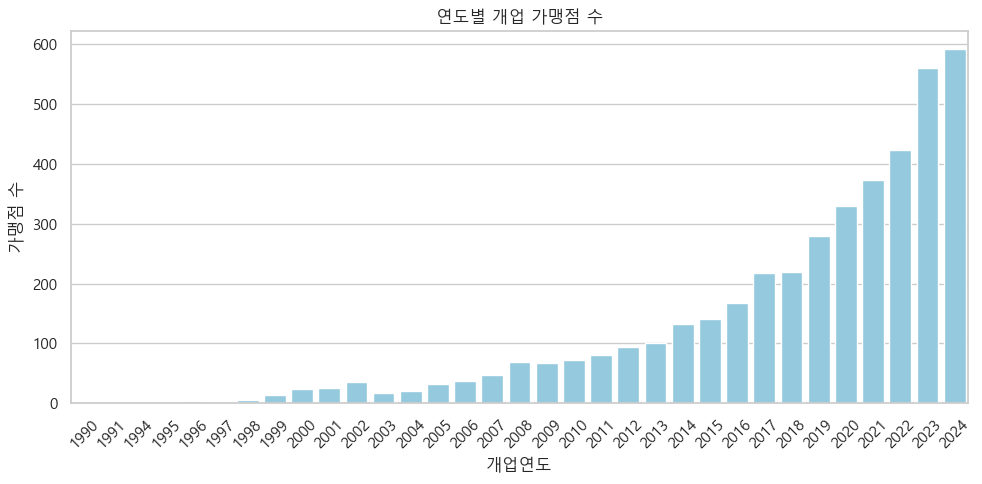

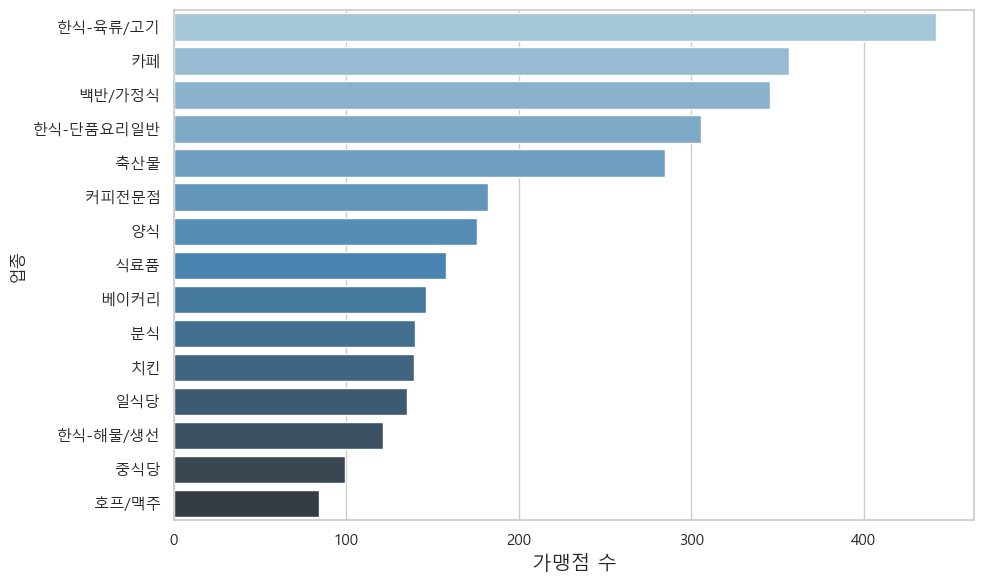

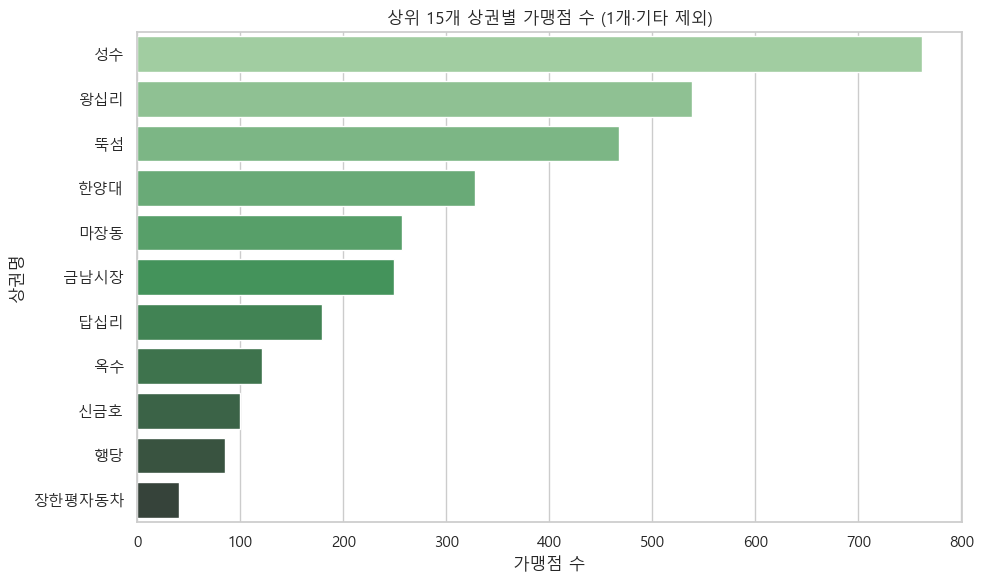

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ======================================================
# ① 전체 가맹점 수
# ======================================================
print(f"전체 가맹점 수: {df_info.shape[0]:,}개")
print(f"컬럼 수: {df_info.shape[1]}개")

# ======================================================
# ② 개업일 분포 (연도별)
# ======================================================
plt.figure(figsize=(10,5))
df_info['open'] = df_info['open'].dt.year
sns.countplot(data=df_info, x='open', color='skyblue')
plt.title("연도별 개업 가맹점 수")
plt.xlabel("개업연도")
plt.ylabel("가맹점 수")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ======================================================
# ③ 업종별 분포 (상위 15개)
# ======================================================
plt.figure(figsize=(10,6))
top_biz = df_info['biz_type'].value_counts().nlargest(15)
sns.barplot(x=top_biz.values, y=top_biz.index, palette="Blues_d")
#plt.title("상위 15개 업종별 가맹점 수")
plt.xlabel("가맹점 수", fontsize = 14)
plt.ylabel("업종")
plt.tight_layout()
plt.show()

# ======================================================
# ④ 상권별 분포 (상위 15개)
# ======================================================
# 상권별 가맹점 수 계산
import seaborn as sns
import matplotlib.pyplot as plt

# 상권별 가맹점 수 계산
market_counts = df_info['market'].value_counts()

# (1) 1개짜리 상권 제거
market_filtered = market_counts[market_counts > 1]

# (2) '기타', NaN 등 제외
exclude_list = ['기타', '없음', '미상', '기타상권']
market_filtered = market_filtered[~market_filtered.index.isin(exclude_list)]

# (3) 상위 15개만 추출
top_market = market_filtered.nlargest(15)

# --- 시각화 ---
plt.figure(figsize=(10,6))
sns.barplot(x=top_market.values, y=top_market.index, palette="Greens_d")
plt.title("상위 15개 상권별 가맹점 수 (1개·기타 제외)")
plt.xlabel("가맹점 수")
plt.ylabel("상권명")
plt.tight_layout()
plt.show()



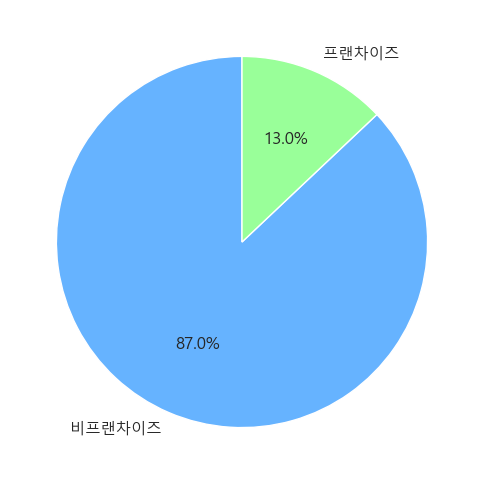

In [99]:
import matplotlib.pyplot as plt

# NaN이면 0, 아니면 1로 프랜차이즈 여부 변수 생성
df_info["is_franchise"] = df_info["brand_cd"].notna().astype(int)

# ======================================================
# ⑤ 프랜차이즈 vs 비프랜차이즈 비율
# ======================================================
plt.figure(figsize=(5,5))
df_info["is_franchise"].value_counts(normalize=True).plot.pie(
    autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#99ff99'],
    labels=["비프랜차이즈", "프랜차이즈"]  # 0=비프랜차이즈, 1=프랜차이즈
)

# plt.title("프랜차이즈 여부 비율")
plt.ylabel("")
plt.tight_layout()
plt.show()


## 2-2. set2

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86590 entries, 0 to 86589
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   num                   86590 non-null  object        
 1   ym                    86590 non-null  datetime64[ns]
 2   oper_month_grp        86590 non-null  category      
 3   sales_grp             86590 non-null  category      
 4   txn_cnt_grp           86590 non-null  category      
 5   cust_cnt_grp          86590 non-null  category      
 6   avg_pay_grp           86590 non-null  category      
 7   cancel_rate_grp       79958 non-null  category      
 8   delivery_sales_ratio  29245 non-null  float64       
 9   rel_sales_ratio       86590 non-null  float64       
 10  rel_txn_ratio         86590 non-null  float64       
 11  sales_rank_industry   86590 non-null  float64       
 12  sales_rank_market     86590 non-null  float64       
 13  share_sales_indu

### 연속형 변수들 hist + 로그화 hist

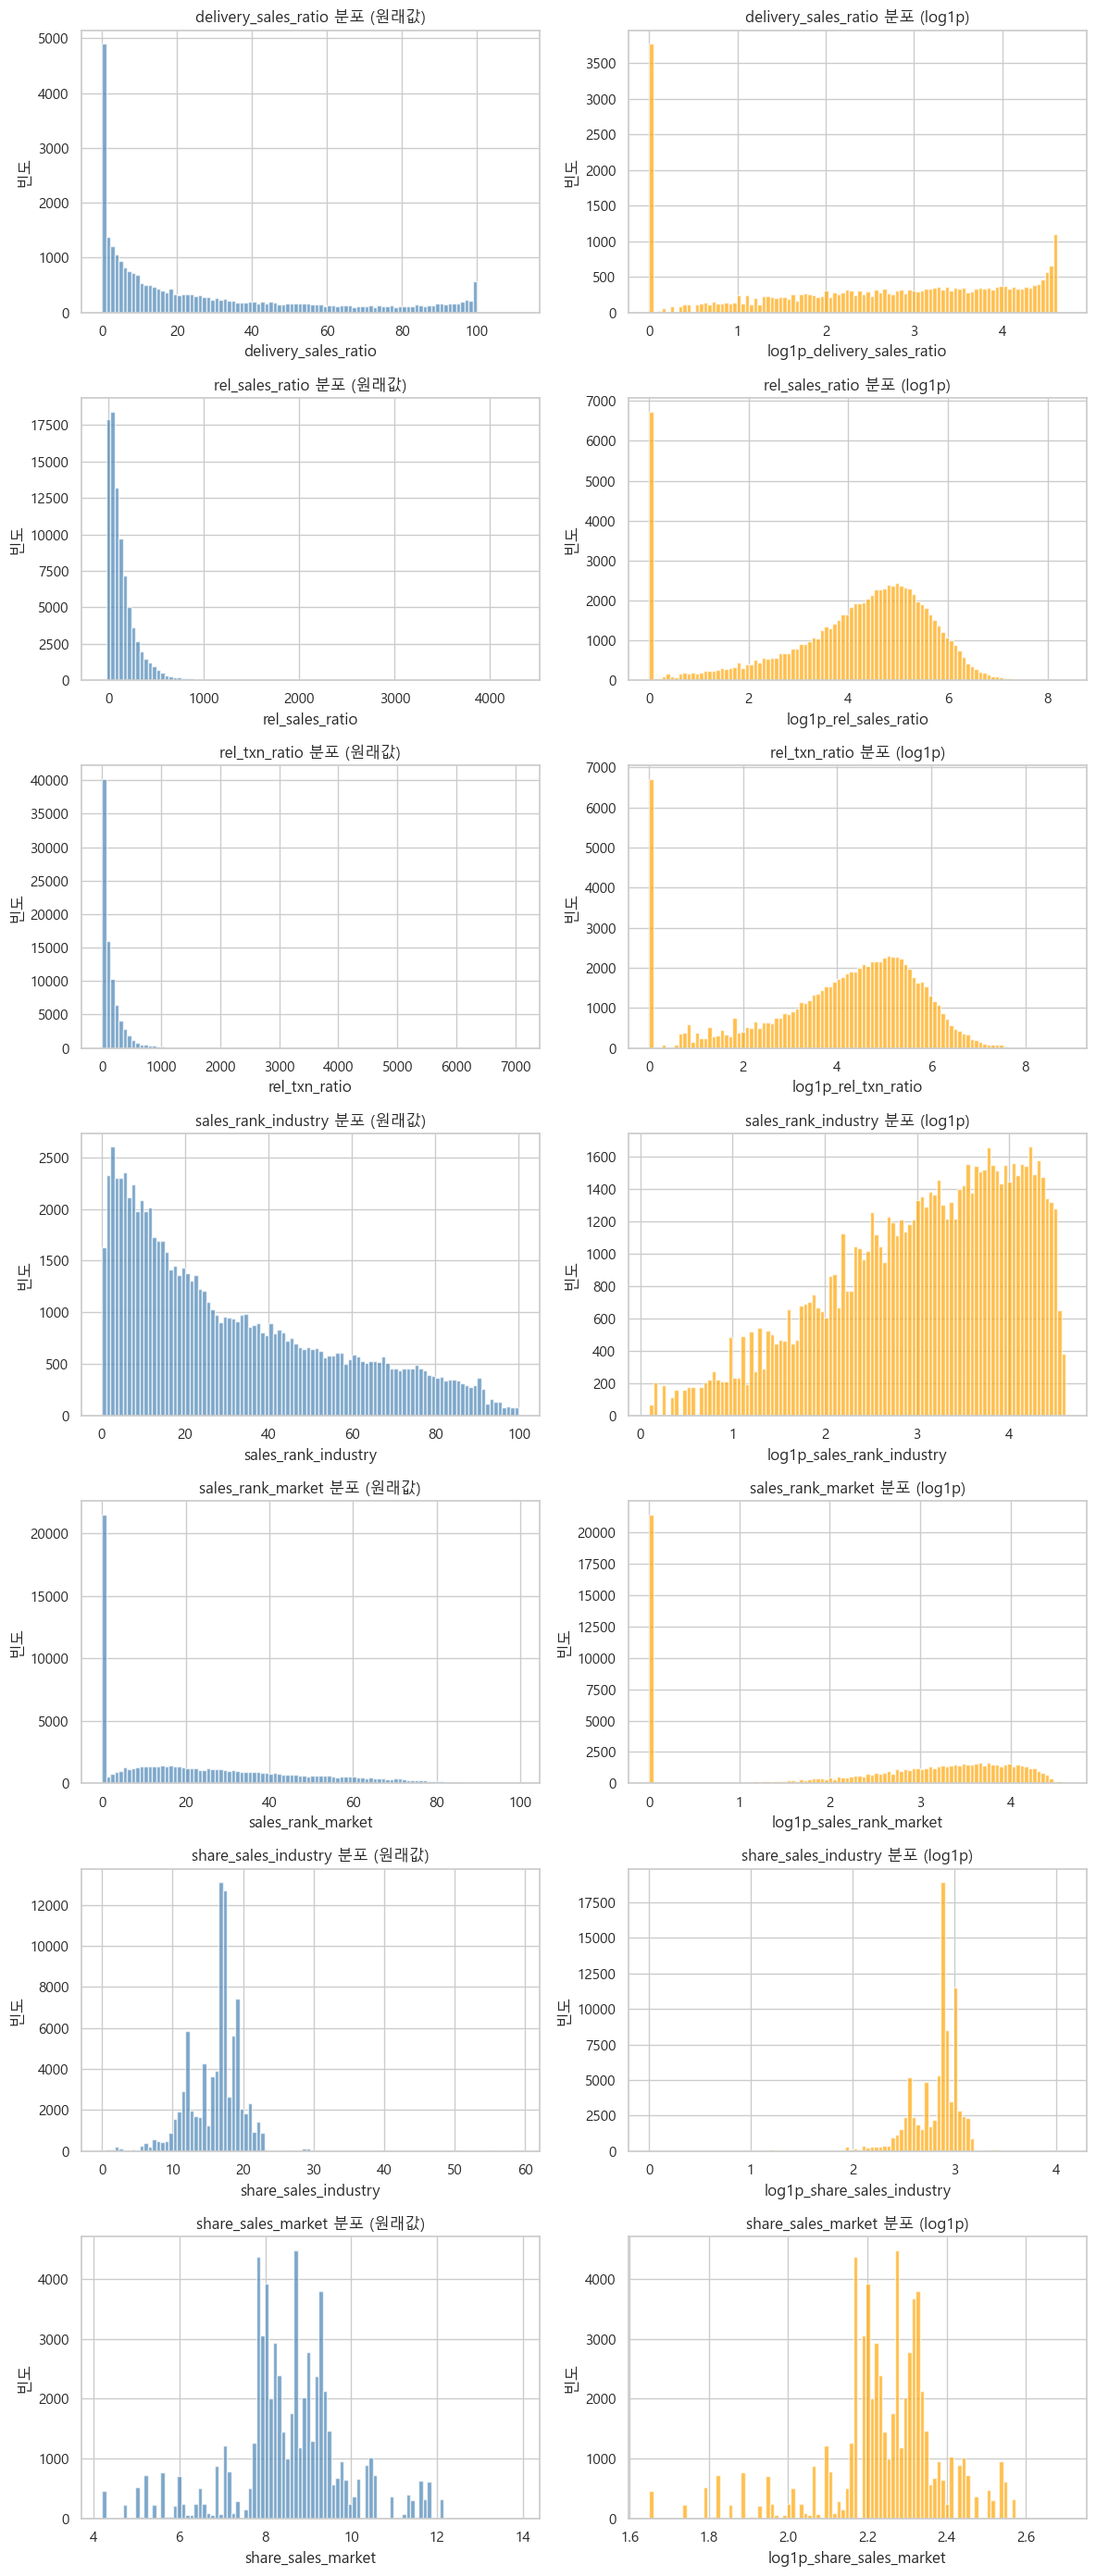

In [101]:
# ===== 한글 폰트 설정 (Windows/macOS/Linux 자동) =====
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform
import numpy as np

plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

system = platform.system()

# 플롯할 주요 비율 변수들
plot_cols = [
    "delivery_sales_ratio","rel_sales_ratio","rel_txn_ratio",
    "sales_rank_industry", "sales_rank_market", "share_sales_industry", "share_sales_market"
]

# 로그 변수를 df에 추가
for col in plot_cols:
    if col in df.columns:
        df[f"log1p_{col}"] = np.log1p(df[col].clip(lower=0))  # 음수 방지용 clip

# 플롯
fig, axes = plt.subplots(len(plot_cols), 2, figsize=(12, 4*len(plot_cols)))

for i, col in enumerate(plot_cols):
    if col not in df.columns:
        continue

    # 원래 값 분포
    axes[i, 0].hist(df[col].dropna(), bins=100, color="steelblue", alpha=0.7)
    axes[i, 0].set_title(f"{col} 분포 (원래값)")
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel("빈도")

    # 로그 변환 값 분포
    log_col = f"log1p_{col}"
    axes[i, 1].hist(df[log_col].dropna(), bins=100, color="orange", alpha=0.7)
    axes[i, 1].set_title(f"{col} 분포 (log1p)")
    axes[i, 1].set_xlabel(log_col)
    axes[i, 1].set_ylabel("빈도")

plt.tight_layout()
plt.show()


### 취소율 barplot

c:\Users\eunseok\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


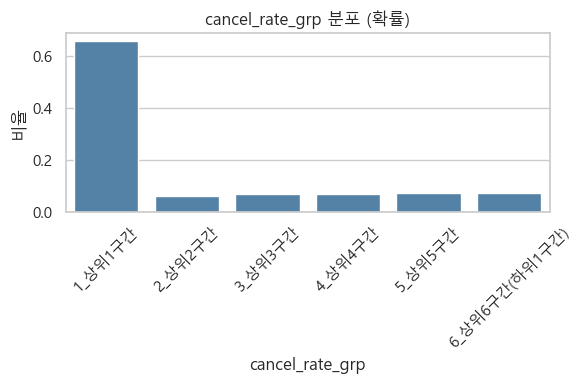

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

col = "cancel_rate_grp"

# 각 그룹별 비율 계산
prop = df[col].value_counts(normalize=True).sort_index()
prop_df = prop.reset_index()
prop_df.columns = [col, "비율"]

# Plot
plt.figure(figsize=(6,4))
sns.barplot(x=col, y="비율", data=prop_df, color="steelblue")

plt.title(f"{col} 분포 (확률)")
plt.xlabel(col)
plt.ylabel("비율")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 0 제외 배달 plot

c:\Users\eunseok\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


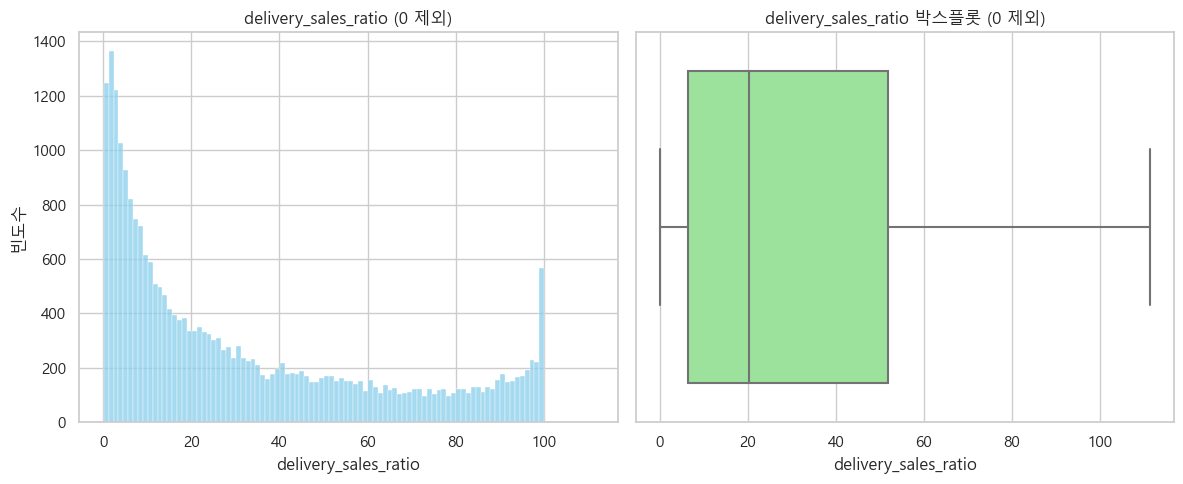

In [103]:

import matplotlib.pyplot as plt
import seaborn as sns

# 0이 아닌 값만 필터링
delivery_nonzero = df[df['delivery_sales_ratio'] > 0]['delivery_sales_ratio']

plt.figure(figsize=(12,5))

# 히스토그램
plt.subplot(1,2,1)
sns.histplot(delivery_nonzero, bins=100, kde=False, color="skyblue")
plt.title("delivery_sales_ratio (0 제외)")
plt.xlabel("delivery_sales_ratio")
plt.ylabel("빈도수")

# 박스플롯
plt.subplot(1,2,2)
sns.boxplot(x=delivery_nonzero, color="lightgreen")
plt.title("delivery_sales_ratio 박스플롯 (0 제외)")
plt.xlabel("delivery_sales_ratio")

plt.tight_layout()
plt.show()


## 2-3. set3 

### 연령대별 재방문/신규

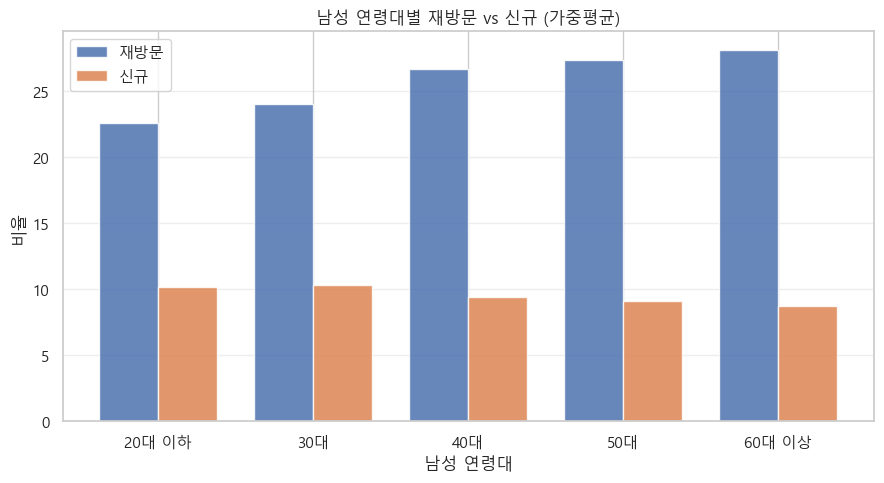

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

male_cols = ['male_20below_ratio', 'male_30_ratio', 'male_40_ratio',
             'male_50_ratio', 'male_60plus_ratio']
age_labels = ['20대 이하','30대','40대','50대','60대 이상']
y_cols = ['revisit_ratio', 'new_ratio']

# 결측 제거
sub = df_final[male_cols + y_cols].dropna(how='any')
if sub.empty:
    raise ValueError("필요한 컬럼에 유효한 값이 없습니다.")

def wavg(y_col, w_col):
    w = sub[w_col]
    den = w.sum()
    return np.nan if den == 0 else (sub[y_col] * w).sum() / den

revisit_vals = [wavg('revisit_ratio', c) for c in male_cols]
new_vals     = [wavg('new_ratio', c)   for c in male_cols]

# ---- barplot ----
x = np.arange(len(age_labels))
width = 0.38

plt.figure(figsize=(9,5))
plt.bar(x - width/2, revisit_vals, width=width, alpha=0.85, label='재방문')
plt.bar(x + width/2, new_vals,     width=width, alpha=0.85, label='신규')

plt.xticks(x, age_labels)
plt.xlabel('남성 연령대')
plt.ylabel('비율')
plt.title('남성 연령대별 재방문 vs 신규 (가중평균)')
plt.legend()
plt.grid(axis='y', alpha=0.35)
plt.tight_layout()
plt.show()


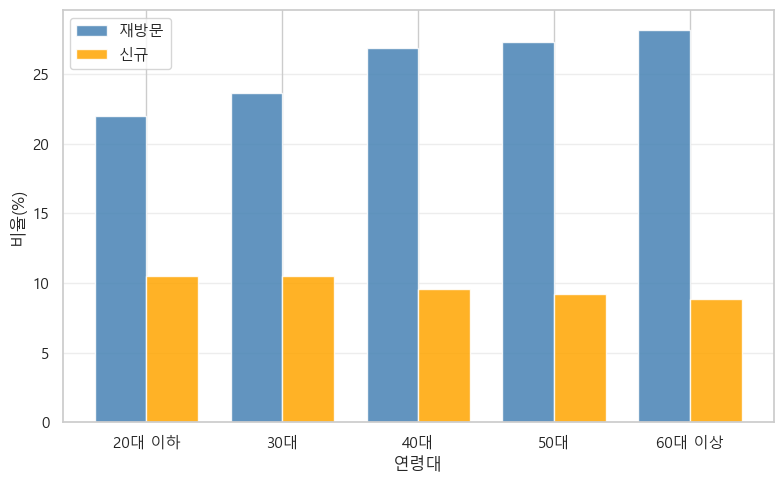

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 연령대별 남성/여성 고객비중 컬럼 ---
male_cols = ['male_20below_ratio', 'male_30_ratio', 'male_40_ratio',
             'male_50_ratio', 'male_60plus_ratio']
female_cols = ['female_20below_ratio', 'female_30_ratio', 'female_40_ratio',
             'female_50_ratio', 'female_60plus_ratio']
age_labels = ['20대 이하', '30대', '40대', '50대', '60대 이상']

# --- y변수 ---
y_cols = ['revisit_ratio', 'new_ratio']

# --- 남녀 합친 전체 연령대 비중 계산 ---
age_total_cols = []
for m_col, f_col in zip(male_cols, female_cols):
    new_col = m_col.replace('남성_', '')  # 예: '20대이하_고객비중'
    df_final[new_col] = df_final[m_col].fillna(0) + df_final[f_col].fillna(0)
    age_total_cols.append(new_col)

# --- 결측 제거 ---
sub = df_final[age_total_cols + y_cols].dropna(how='any')

# --- 가중평균 계산 함수 ---
def wavg(y_col, w_col):
    w = sub[w_col]
    den = w.sum()
    return np.nan if den == 0 else (sub[y_col] * w).sum() / den

# 각 연령대별 가중평균 계산
revisit_vals = [wavg('revisit_ratio', c) for c in age_total_cols]
new_vals     = [wavg('new_ratio', c)   for c in age_total_cols]

# --- 시각화 ---
x = np.arange(len(age_labels))
width = 0.38

plt.figure(figsize=(8,5))
plt.bar(x - width/2, revisit_vals, width=width, color='steelblue', alpha=0.85, label='재방문')
plt.bar(x + width/2, new_vals,     width=width, color='orange', alpha=0.85, label='신규')

plt.xticks(x, age_labels)
plt.xlabel('연령대')
plt.ylabel('비율(%)')
#plt.title('연령대별 재방문 vs 신규 고객비율 (남녀 통합)')
plt.legend()
plt.grid(axis='y', alpha=0.35)
plt.tight_layout()
plt.show()


### 연령대별 거주/직장/유동

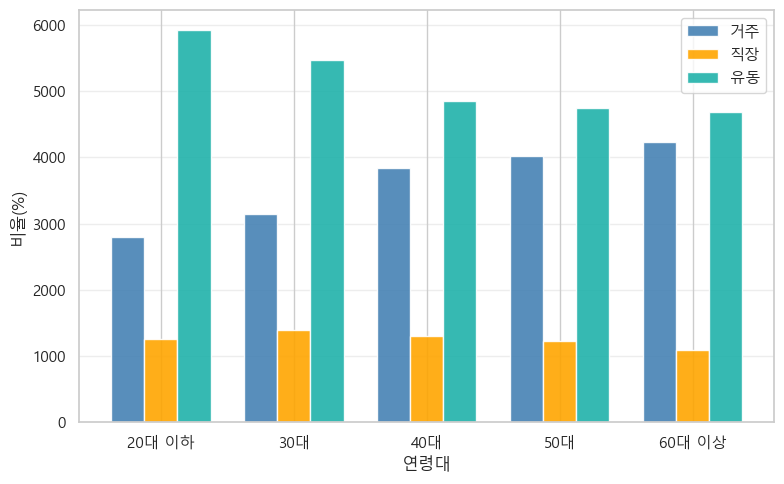

In [112]:

# --- 이용유형 비율 컬럼 ---
use_cols = ['resident_ratio', 'worker_ratio', 'floating_ratio']  # 순서 유지

# --- 남녀 합친 연령대 가중치 컬럼 생성 ---
age_total_cols = []
for m_col, f_col in zip(male_cols, female_cols):
    new_col = m_col.replace('남성_', '')  # 예: '20대이하_고객비중'
    df_final[new_col] = df_final[m_col].fillna(0) + df_final[f_col].fillna(0)
    age_total_cols.append(new_col)

# --- 결측 제거(사용 컬럼만) ---
sub = df_final[age_total_cols + use_cols].dropna(how='any')

# --- 가중평균 함수 ---
def wavg(y_col, w_col):
    w = sub[w_col].astype(float)
    den = w.sum()
    return np.nan if den == 0 else float((sub[y_col].astype(float) * w).sum() / den)

# 연령대별 가중평균 계산 (남녀 통합 가중치 사용)
resid_vals = [wavg('resident_ratio',   c) for c in age_total_cols]
work_vals  = [wavg('worker_ratio',   c) for c in age_total_cols]
flow_vals  = [wavg('floating_ratio', c) for c in age_total_cols]

# 비율이 0~1이면 %로 보기 원하면 주석 해제
to_pct = True
if to_pct:
    resid_vals = np.array(resid_vals) * 100
    work_vals  = np.array(work_vals)  * 100
    flow_vals  = np.array(flow_vals)  * 100
    ylab = '비율(%)'
else:
    ylab = '비율'

# --- 시각화: 연령대마다 3개 막대 (거주/직장/유동) ---
x = np.arange(len(age_labels))
width = 0.25

plt.figure(figsize=(8,5))
plt.bar(x - width, resid_vals, width=width, label='거주',  alpha=0.9 ,color='#4682B4')
plt.bar(x,         work_vals,  width=width, label='직장',  alpha=0.9, color='#FFA500')
plt.bar(x + width, flow_vals,  width=width, label='유동',  alpha=0.9, color = '#20B2AA')

plt.xticks(x, age_labels, rotation=0)
plt.xlabel('연령대')
plt.ylabel(ylab)
#plt.title('연령대별 이용유형 비율 (남녀 통합, 거주·직장·유동)')
plt.legend()
plt.grid(axis='y', alpha=0.35)
plt.tight_layout()
plt.show()


# 3. 상관관계, 다중공선성 확인

In [113]:
df_final.columns

Index(['num', 'ym', 'oper_month_grp', 'sales_grp', 'txn_cnt_grp',
       'cust_cnt_grp', 'avg_pay_grp', 'cancel_rate_grp',
       'delivery_sales_ratio', 'rel_sales_ratio', 'rel_txn_ratio',
       'sales_rank_industry', 'sales_rank_market', 'share_sales_industry',
       'share_sales_market', 'male_20below_ratio', 'male_30_ratio',
       'male_40_ratio', 'male_50_ratio', 'male_60plus_ratio',
       'female_20below_ratio', 'female_30_ratio', 'female_40_ratio',
       'female_50_ratio', 'female_60plus_ratio', 'revisit_ratio', 'new_ratio',
       'resident_ratio', 'worker_ratio', 'floating_ratio', 'addr', 'name',
       'brand_cd', 'sigungu', 'biz_type', 'market', 'open', 'close',
       'is_closed'],
      dtype='object')

In [114]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86590 entries, 0 to 86589
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   num                   86590 non-null  object        
 1   ym                    86590 non-null  datetime64[ns]
 2   oper_month_grp        86590 non-null  category      
 3   sales_grp             86590 non-null  category      
 4   txn_cnt_grp           86590 non-null  category      
 5   cust_cnt_grp          86590 non-null  category      
 6   avg_pay_grp           86590 non-null  category      
 7   cancel_rate_grp       79958 non-null  category      
 8   delivery_sales_ratio  29245 non-null  float64       
 9   rel_sales_ratio       86590 non-null  float64       
 10  rel_txn_ratio         86590 non-null  float64       
 11  sales_rank_industry   86590 non-null  float64       
 12  sales_rank_market     86590 non-null  float64       
 13  share_sales_indu

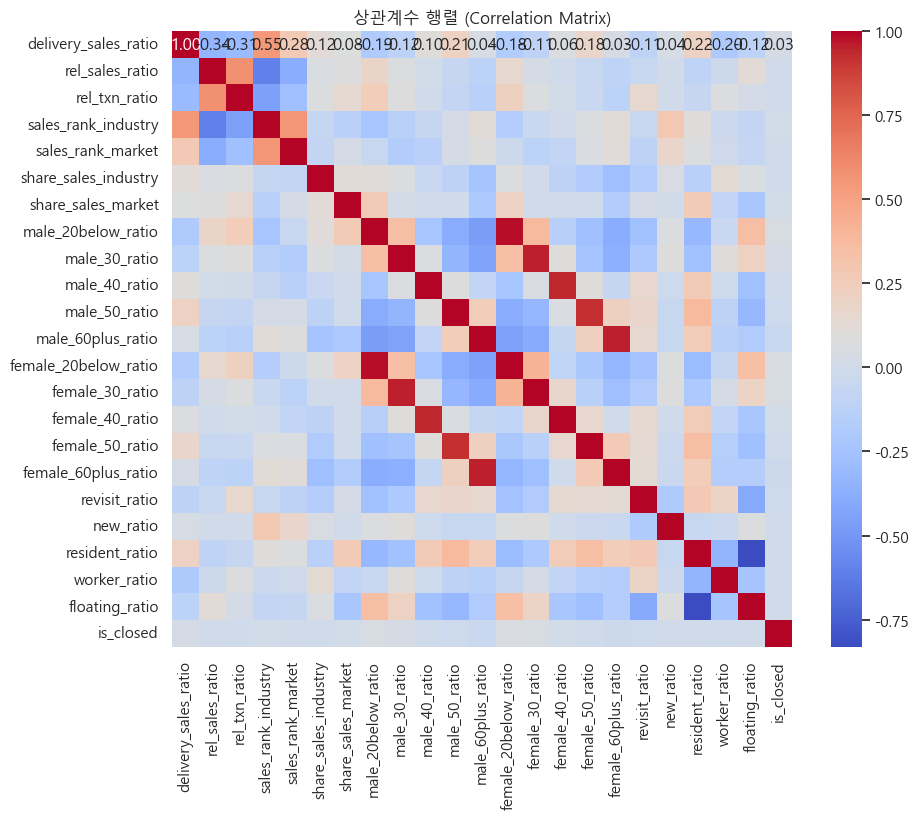

                Variable           VIF
0                  const  6.855671e+06
1   delivery_sales_ratio  1.588015e+00
2        rel_sales_ratio  2.624997e+00
3          rel_txn_ratio  2.279660e+00
4    sales_rank_industry  7.785273e+00
5      sales_rank_market  7.323704e+00
6   share_sales_industry  1.145183e+00
7     share_sales_market  1.351846e+00
8     male_20below_ratio  3.641096e+05
9          male_30_ratio  1.055771e+05
10         male_40_ratio  5.289850e+04
11         male_50_ratio  6.282455e+04
12     male_60plus_ratio  6.999106e+04
13  female_20below_ratio  1.183205e+05
14       female_30_ratio  4.000823e+04
15       female_40_ratio  1.708362e+04
16       female_50_ratio  1.724461e+04
17   female_60plus_ratio  1.691257e+04
18         revisit_ratio  1.640686e+00
19             new_ratio  1.352603e+00
20        resident_ratio  2.135536e+05
21          worker_ratio  6.974425e+04
22        floating_ratio  1.685888e+05
23             is_closed  1.012749e+00


In [118]:

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
plt.rcParams['axes.unicode_minus'] = False  # minus 기호 깨짐 방지


# 분석 대상 열 (수치형 또는 인코딩된 ordinal 변수만 포함)
cols_for_check = [
    'delivery_sales_ratio', 'rel_sales_ratio', 'rel_txn_ratio',
    'sales_rank_industry', 'sales_rank_market', 'share_sales_industry',
    'share_sales_market', 'male_20below_ratio', 'male_30_ratio',
    'male_40_ratio', 'male_50_ratio', 'male_60plus_ratio',
    'female_20below_ratio', 'female_30_ratio', 'female_40_ratio',
    'female_50_ratio', 'female_60plus_ratio', 'revisit_ratio', 'new_ratio',
    'resident_ratio', 'worker_ratio', 'floating_ratio',
    'is_closed'
]


# 1. 상관계수 행렬 시각화
corr = df_final[cols_for_check].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("상관계수 행렬 (Correlation Matrix)")
plt.show()

# 2. VIF 계산
X = add_constant(df_final[cols_for_check].dropna())  # 상수항 추가
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)


# 4. ACF

## 동일업종_매출금액_비율 ACF

In [ ]:
df_final.columns

Index(['num', 'ym', 'oper_month_grp', 'sales_grp', 'txn_cnt_grp',
       'cust_cnt_grp', 'avg_pay_grp', 'cancel_rate_grp',
       'delivery_sales_ratio', 'rel_sales_ratio', 'rel_txn_ratio',
       'sales_rank_industry', 'sales_rank_market', 'share_sales_industry',
       'share_sales_market', 'male_20below_ratio', 'male_30_ratio',
       'male_40_ratio', 'male_50_ratio', 'male_60plus_ratio',
       'female_20below_ratio', 'female_30_ratio', 'female_40_ratio',
       'female_50_ratio', 'female_60plus_ratio', 'revisit_ratio', 'new_ratio',
       'resident_ratio', 'worker_ratio', 'floating_ratio', 'addr', 'name',
       'brand_cd', 'sigungu', 'biz_type', 'market', 'open', 'close',
       'is_closed'],
      dtype='object')

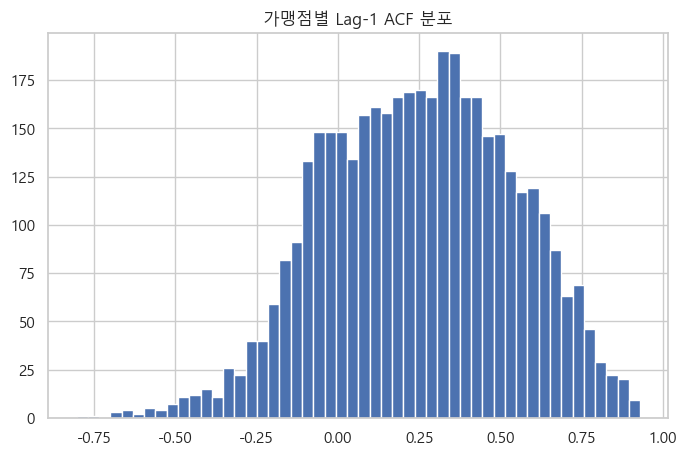

In [ ]:
from statsmodels.tsa.stattools import acf

acf_vals = []
for num, grp in df_final.groupby("num"):
    series = grp.sort_values("ym")["rel_sales_ratio"]
    if len(series) > 2:  # 최소 길이 조건
        acf_val = acf(series, nlags=12)[1]  # lag=1 값
        acf_vals.append(acf_val)

plt.figure(figsize=(8,5))
plt.hist(acf_vals, bins=50)
plt.title("가맹점별 Lag-1 ACF 분포")
plt.show()


## 동일업종_내_매출순위_비율 ACF

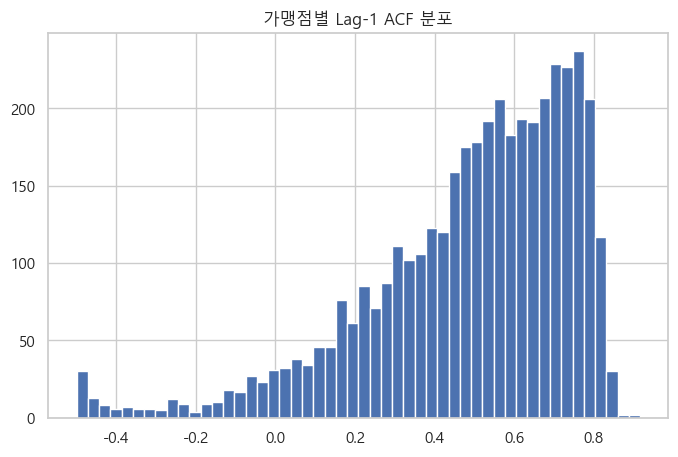

In [ ]:
from statsmodels.tsa.stattools import acf

acf_vals = []
for num, grp in df_final.groupby("num"):
    series = grp.sort_values("ym")["sales_rank_industry"]
    if len(series) > 2:  # 최소 길이 조건
        acf_val = acf(series, nlags=12)[2]  # lag=1 값
        acf_vals.append(acf_val)

plt.figure(figsize=(8,5))
plt.hist(acf_vals, bins=50)
plt.title("가맹점별 Lag-1 ACF 분포")
plt.show()
